In [25]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Layer, Reshape, Multiply, Conv2D, BatchNormalization, Activation, Add, Input, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_uniform
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedShuffleSplit


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [26]:
base = '/home/rob/'
csv_file = os.path.join(base, 'ham10000_data/HAM10000_metadata.csv')
img_dir = os.path.join(base, 'ham10000_data/images')
file_ext = '.jpg'

df = pd.read_csv(csv_file)
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(img_dir, x + file_ext))

print(df.head())


     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                        image_path  
0  /home/rob/ham10000_data/images/ISIC_0027419.jpg  
1  /home/rob/ham10000_data/images/ISIC_0025030.jpg  
2  /home/rob/ham10000_data/images/ISIC_0026769.jpg  
3  /home/rob/ham10000_data/images/ISIC_0025661.jpg  
4  /home/rob/ham10000_data/images/ISIC_0031633.jpg  


In [27]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in sss.split(df, df['dx']):
    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

print("Train size: ", len(train_df))
print("Train sizes per label and percentage:")
train_counts = train_df['dx'].value_counts()
train_percentages = (train_counts / len(train_df)) * 100
print(train_counts)
print(train_percentages)

print("\nTest size: ", len(test_df))
print("Test sizes per label and percentage:")
test_counts = test_df['dx'].value_counts()
test_percentages = (test_counts / len(test_df)) * 100
print(test_counts)
print(test_percentages)

Train size:  8012
Train sizes per label and percentage:
dx
nv       5364
mel       890
bkl       879
bcc       411
akiec     262
vasc      114
df         92
Name: count, dtype: int64
dx
nv       66.949576
mel      11.108337
bkl      10.971043
bcc       5.129805
akiec     3.270095
vasc      1.422866
df        1.148278
Name: count, dtype: float64

Test size:  2003
Test sizes per label and percentage:
dx
nv       1341
mel       223
bkl       220
bcc       103
akiec      65
vasc       28
df         23
Name: count, dtype: int64
dx
nv       66.949576
mel      11.133300
bkl      10.983525
bcc       5.142287
akiec     3.245132
vasc      1.397903
df        1.148278
Name: count, dtype: float64


In [28]:
IMG_SIZE = 224
BATCH_SIZE = 32

datagen_train = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_test = ImageDataGenerator(rescale=1.0/255.0)

train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42,
)

class_names = [key for key, _ in sorted(train_generator.class_indices.items(), key=lambda item: item[1])]

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None, len(class_names)])
).repeat()
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, IMG_SIZE, IMG_SIZE, 3], [None, len(class_names)])
).repeat()
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

print("Class Names:", class_names)
print("Train Generator Class Indices:", train_generator.class_indices)
print("Test Generator Class Indices:", test_generator.class_indices)

Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Class Names: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Train Generator Class Indices: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Test Generator Class Indices: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [29]:
import tensorflow as tf
from tensorflow.keras import layers

class SEBlock(layers.Layer):
    """
    Squeeze-and-Excitation (SE) Block

    The SE block recalibrates channel-wise feature responses by explicitly modeling
    interdependencies between channels. Given an input feature map of shape
    (batch, height, width, channels), it:

    1. Squeezes global spatial information into a channel descriptor by using
       global average pooling.
    2. Excites each channel by passing this descriptor through a fully-connected
       bottleneck and expanding transformation, utilizing a sigmoid activation
       to generate channel-wise weights.
    3. Scales the original feature map by these learned weights,
       reinforcing channels that are relevant and suppressing those that are not.

    Parameters
    ----------
    reduction_ratio : int, optional (default=16)
        The reduction ratio used to compute the size of the bottleneck layer.
        For an input with `C` channels, the bottleneck layer will have
        `C // reduction_ratio` channels.

    name : str, optional
        String name for the layer.

    Attributes
    ----------
    fc1 : Dense layer
        The first fully connected layer that reduces the channel dimension.
    fc2 : Dense layer
        The second fully connected layer that expands back to the original channel dimension.
    """
    def __init__(self, reduction_ratio=16, name=None, **kwargs):
        super(SEBlock, self).__init__(name=name, **kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        """
        Build the internal layers of the SE block. This method is called
        automatically once the shape of the inputs is known.

        Parameters
        ----------
        input_shape : TensorShape
            The shape of the input tensor. Typically (batch, height, width, channels).
        """
        if len(input_shape) != 4:
            raise ValueError("SEBlock only supports inputs with shape (batch, height, width, channels).")

        channels = input_shape[-1]
        reduced_channels = max(channels // self.reduction_ratio, 1)

        # First FC layer for reduction (C -> C//r)
        self.fc1 = layers.Dense(units=reduced_channels,
                                activation='relu',  # Non-linear activation
                                use_bias=True,
                                name='se_fc1')

        # Second FC layer to restore original dimension (C//r -> C)
        self.fc2 = layers.Dense(units=channels,
                                activation='sigmoid',  # Outputs channel-wise gating weights
                                use_bias=True,
                                name='se_fc2')

        super(SEBlock, self).build(input_shape)

    def call(self, inputs, training=False):
        """
        Forward pass of the SE block.

        Steps:
        1. Global average pooling to get channel-wise statistics of shape (batch, channels).
        2. Pass through the first FC layer (reduction).
        3. Pass through the second FC layer (expansion) with sigmoid activation to get weights.
        4. Reshape weights to (batch, 1, 1, channels) to match the input shape.
        5. Multiply the original inputs by these weights (channel-wise scaling).

        Parameters
        ----------
        inputs : tf.Tensor
            The input tensor with shape (batch, height, width, channels).

        training : bool, optional
            Specifies if the layer should behave in training mode or inference mode.
            This parameter can be used by certain layers that behave differently
            during training and inference.

        Returns
        -------
        tf.Tensor
            The output tensor with the same shape as `inputs`, after channel-wise rescaling.
        """
        # Step 1: Squeeze
        # Global average pooling: (batch, H, W, C) -> (batch, C)
        squeeze_tensor = tf.reduce_mean(inputs, axis=[1, 2], keepdims=False)

        # Step 2 & 3: Excitation
        # FC reduce: (batch, C) -> (batch, C//r)
        reduced = self.fc1(squeeze_tensor, training=training)
        # FC expand: (batch, C//r) -> (batch, C)
        excitation = self.fc2(reduced, training=training)

        # Reshape excitation to (batch, 1, 1, C) for broadcasting
        excitation = tf.reshape(excitation, [-1, 1, 1, tf.shape(inputs)[-1]])

        # Step 4: Scale
        # Scale input by the learned weights: (batch, H, W, C)
        scaled_inputs = inputs * excitation
        return scaled_inputs

    def compute_output_shape(self, input_shape):
        """
        Compute the output shape of the SE block. It remains the same as the input shape.

        Parameters
        ----------
        input_shape : Tuple[int]
            Shape of the input tensor.

        Returns
        -------
        Tuple[int]
            The output shape, identical to the input shape.
        """
        return input_shape

    def get_config(self):
        """
        Returns the configuration of the layer. This enables the layer
        to be serialized and deserialized, for example, when saving and loading models.

        Returns
        -------
        dict
            A dictionary containing the layer configuration.
        """
        config = super(SEBlock, self).get_config()
        config.update({
            'reduction_ratio': self.reduction_ratio
        })
        return config


In [30]:
# Source: https://github.com/keras-team/keras/blob/v3.7.0/keras/src/applications/resnet.py#L219
# This implementation of ResNet50 is adapted from the official Keras implementation,
# to enable the modification of the architecture to support attention mechanisms.

def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of the middle conv layer at the main path
        filters: list of integers, the filters of the 3 conv layers at the main path
        stage: integer, current stage label, used for layer naming
        block: string/char, current block label, used for layer naming
    """
    # Use channels_last
    bn_axis = 3
    filters1, filters2, filters3 = filters
    conv_name_base = 'conv' + str(stage) + '_block' + str(block) + '_'

    x = Conv2D(filters1, (1, 1),
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '1_conv')(input_tensor)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '1_bn')(x)
    x = Activation('relu', name=conv_name_base + '1_relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same',
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '2_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '2_bn')(x)
    x = Activation('relu', name=conv_name_base + '2_relu')(x)

    x = Conv2D(filters3, (1, 1),
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '3_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '3_bn')(x)

    x = Add(name=conv_name_base + 'add')([x, input_tensor])
    x = Activation('relu', name=conv_name_base + 'out')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of the middle conv layer at the main path
        filters: list of integers, the filters of the 3 conv layers at the main path
        stage: integer, current stage label, used for layer naming
        block: string/char, current block label, used for layer naming
        strides: Strides for the first conv layer in the block.
    """
    bn_axis = 3
    filters1, filters2, filters3 = filters
    conv_name_base = 'conv' + str(stage) + '_block' + str(block) + '_'

    x = Conv2D(filters1, (1, 1), strides=strides,
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '1_conv')(input_tensor)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '1_bn')(x)
    x = Activation('relu', name=conv_name_base + '1_relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '2_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '2_bn')(x)
    x = Activation('relu', name=conv_name_base + '2_relu')(x)

    x = Conv2D(filters3, (1, 1),
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '3_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '3_bn')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      use_bias=True,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '0_conv')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '0_bn')(shortcut)

    x = Add(name=conv_name_base + 'add')([x, shortcut])
    x = Activation('relu', name=conv_name_base + 'out')(x)
    return x

def build_resnet50(input_shape, num_classes):
    inputs = Input(shape=input_shape, name='input_1')
    bn_axis = 3  # channels_last

    x = ZeroPadding2D(padding=(3, 3), name='conv1_pad')(inputs)
    x = Conv2D(64, (7, 7), strides=(2, 2),
               padding='valid', use_bias=True,
               kernel_initializer='he_normal',
               name='conv1_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv1_bn')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1_pool')(x)

    # Stage 2
    x = conv_block(x, 3, [64, 64, 256], stage=2, block=1, strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block=2)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block=3)

    # Stage 3
    x = conv_block(x, 3, [128, 128, 512], stage=3, block=1)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=2)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=3)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=4)

    # Stage 4
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block=1)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=2)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=3)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=4)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=5)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=6)

    # Stage 5
    x = conv_block(x, 3, [512, 512, 2048], stage=5, block=1)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block=2)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block=3)

    x = SEBlock()(x)

    x = GlobalAveragePooling2D(name='avg_pool')(x)

    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', name='predictions')(x)

    model = Model(inputs, outputs, name='resnet50')
    return model


In [31]:
def transfer_weights(base_model, target_model):
    for layer in target_model.layers:
        try:
            pretrained_layer = base_model.get_layer(layer.name)
            layer.set_weights(pretrained_layer.get_weights())
        except Exception as e:
            print(f"Could not transfer weights for layer: {layer.name}, due to: {e}")
            pass

In [32]:
base_model = ResNet50(weights="imagenet", include_top=False, pooling=None)

# Build ResNet50 with SE Blocks
input_shape = (224, 224, 3)
num_classes = 7
custom_resnet = build_resnet50(input_shape, num_classes)

# Transfer weights
transfer_weights(base_model, custom_resnet)

custom_resnet.summary()

# Switch the custom_resnet to being the model
model = custom_resnet

# Freeze the base model
for layer in model.layers:
    if layer.name.startswith('conv1') or layer.name.startswith('conv2') or layer.name.startswith('conv3') or layer.name.startswith('conv4') or layer.name.startswith('conv5'):
        layer.trainable = False


Could not transfer weights for layer: input_1, due to: No such layer: input_1. Existing layers are: ['input_layer_1', 'conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'pool1_pad', 'pool1_pool', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_conv', 'conv2_block1_2_bn', 'conv2_block1_2_relu', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block1_0_bn', 'conv2_block1_3_bn', 'conv2_block1_add', 'conv2_block1_out', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_conv', 'conv2_block2_2_bn', 'conv2_block2_2_relu', 'conv2_block2_3_conv', 'conv2_block2_3_bn', 'conv2_block2_add', 'conv2_block2_out', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_conv', 'conv2_block3_2_bn', 'conv2_block3_2_relu', 'conv2_block3_3_conv', 'conv2_block3_3_bn', 'conv2_block3_add', 'conv2_block3_out', 'conv3_block1_1_conv', 'conv3_block1_1_bn', 'conv3_block1_1_relu', 'conv3_block1_2_conv', 'conv3_block1_

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_3 (Cast)       │ (None, 224, 224,  │          0 │ input_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ cast_3[0][0]      │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 23,548,935 (89.83 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [33]:
def focal_loss(alpha=0.25, gamma=2.0):
    """
    Focal Loss for one-hot encoded multi-class data.
    Source:
    https://github.com/fizyr/keras-retinanet/blob/main/keras_retinanet/losses.py
    Paper:
    https://arxiv.org/abs/1708.02002


    Parameters:
    - alpha: Weighting factor for positive classes, default is 0.25.
    - gamma: Focusing parameter to reduce the loss contribution from well-classified examples, default is 2.0.

    Returns:
    - A callable loss function for use with Keras models.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())

        # Compute focal loss components
        cross_entropy = -y_true * tf.math.log(y_pred)
        weights = alpha * y_true * tf.math.pow(1 - y_pred, gamma)

        # Compute weighted loss
        focal_loss = tf.reduce_sum(weights * cross_entropy, axis=-1)
        return tf.reduce_mean(focal_loss)

    return focal_loss_fixed


In [34]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [35]:
model_path = 'models/resnet50.keras'

callbacks = [
    EarlyStopping(monitor='val_auc', patience=3, verbose=1, restore_best_weights=True, mode='max'),
    ModelCheckpoint(filepath=model_path, monitor='val_auc', save_best_only=True, verbose=1, mode='max')
]

In [36]:
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.array(class_names),
    y=df['dx']
)

class_weights_dict = {
    train_generator.class_indices[class_name]: weight
    for class_name, weight in zip(class_names, class_weights_array)
}

print(class_weights_dict)

{0: np.float64(4.375273044997815), 1: np.float64(2.78349082823791), 2: np.float64(1.301832835044846), 3: np.float64(12.440993788819876), 4: np.float64(1.2854575792581184), 5: np.float64(0.21338020666879728), 6: np.float64(10.075452716297788)}


In [37]:
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(test_df) // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.5878 - auc: 0.8296 - loss: 0.2150
Epoch 1: val_auc improved from -inf to 0.88177, saving model to models/resnet50.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 156s 579ms/step - accuracy: 0.5880 - auc: 0.8297 - loss: 0.2150 - val_accuracy: 0.6699 - val_auc: 0.8818 - val_loss: 0.1725
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.6657 - auc: 0.8726 - loss: 0.1880
Epoch 2: val_auc improved from 0.88177 to 0.88726, saving model to models/resnet50.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 139s 544ms/step - accuracy: 0.6657 - auc: 0.8726 - loss: 0.1880 - val_accuracy: 0.6687 - val_auc: 0.8873 - val_loss: 0.1718
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.6659 - auc: 0.8759 - loss: 0.1912
Epoch 3: val_auc improved from 0.88726 to 0.89232, saving model to models/resnet50.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 132s 530ms/step - accuracy: 0.6659 - auc: 0.8759 - loss: 0.1912 - val_accuracy: 0.6677 - val_au

In [38]:
for layer in model.layers:
    layer.trainable = True
    print(layer.name, layer.trainable)

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=focal_loss(),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)


input_1 True
conv1_pad True
conv1_conv True
conv1_bn True
conv1_relu True
pool1_pad True
pool1_pool True
conv2_block1_1_conv True
conv2_block1_1_bn True
conv2_block1_1_relu True
conv2_block1_2_conv True
conv2_block1_2_bn True
conv2_block1_2_relu True
conv2_block1_3_conv True
conv2_block1_0_conv True
conv2_block1_3_bn True
conv2_block1_0_bn True
conv2_block1_add True
conv2_block1_out True
conv2_block2_1_conv True
conv2_block2_1_bn True
conv2_block2_1_relu True
conv2_block2_2_conv True
conv2_block2_2_bn True
conv2_block2_2_relu True
conv2_block2_3_conv True
conv2_block2_3_bn True
conv2_block2_add True
conv2_block2_out True
conv2_block3_1_conv True
conv2_block3_1_bn True
conv2_block3_1_relu True
conv2_block3_2_conv True
conv2_block3_2_bn True
conv2_block3_2_relu True
conv2_block3_3_conv True
conv2_block3_3_bn True
conv2_block3_add True
conv2_block3_out True
conv3_block1_1_conv True
conv3_block1_1_bn True
conv3_block1_1_relu True
conv3_block1_2_conv True
conv3_block1_2_bn True
conv3_block1

In [39]:
callbacks = [
    ReduceLROnPlateau(monitor='val_auc', factor=0.1, patience=3, verbose=1, mode='max', min_lr=1e-9),
    EarlyStopping(monitor='val_auc', patience=7, verbose=1, restore_best_weights=True, mode='max'),
    ModelCheckpoint(filepath=model_path, monitor='val_auc', save_best_only=True, verbose=1, mode='max')
]

In [40]:
fine_tune_history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=200,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weights_dict
)


Epoch 1/200


2024-12-17 09:55:39.695440: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'copy_fusion_50', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'copy_fusion_44', 4 bytes spill stores, 12 bytes spill loads



  1/250 ━━━━━━━━━━━━━━━━━━━━ 4:23:09 63s/step - accuracy: 0.5625 - auc: 0.8416 - loss: 0.3390

2024-12-17 09:56:09.834125: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_divide_multiply_reduce_fusion_6', 20 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_divide_multiply_reduce_fusion_2', 20 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_divide_multiply_reduce_fusion', 20 bytes spill stores, 20 bytes spill loads



250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.5965 - auc: 0.8622 - loss: 0.4305
Epoch 1: val_auc improved from -inf to 0.82048, saving model to models/resnet50.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 237s 697ms/step - accuracy: 0.5965 - auc: 0.8623 - loss: 0.4304 - val_accuracy: 0.6657 - val_auc: 0.8205 - val_loss: 0.8970 - learning_rate: 1.0000e-05
Epoch 2/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.6541 - auc: 0.9125 - loss: 0.2398
Epoch 2: val_auc did not improve from 0.82048
250/250 ━━━━━━━━━━━━━━━━━━━━ 133s 535ms/step - accuracy: 0.6541 - auc: 0.9124 - loss: 0.2398 - val_accuracy: 0.6722 - val_auc: 0.8078 - val_loss: 1.2836 - learning_rate: 1.0000e-05
Epoch 3/200
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.6754 - auc: 0.9283 - loss: 0.1802
Epoch 3: val_auc improved from 0.82048 to 0.84493, saving model to models/resnet50.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 136s 545ms/step - accuracy: 0.6754 - auc: 0.9283 - loss: 0.1802 - val_accuracy: 0.6707 - va

In [41]:
model.load_weights(model_path)


In [42]:
loss, accuracy, auc = model.evaluate(test_generator, steps=len(test_generator))

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test AUC: {auc}")

/home/rob/.notebook/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - accuracy: 0.8256 - auc: 0.9821 - loss: 0.0643
Test Loss: 0.05809102579951286
Test Accuracy: 0.8432351350784302
Test AUC: 0.9844887256622314


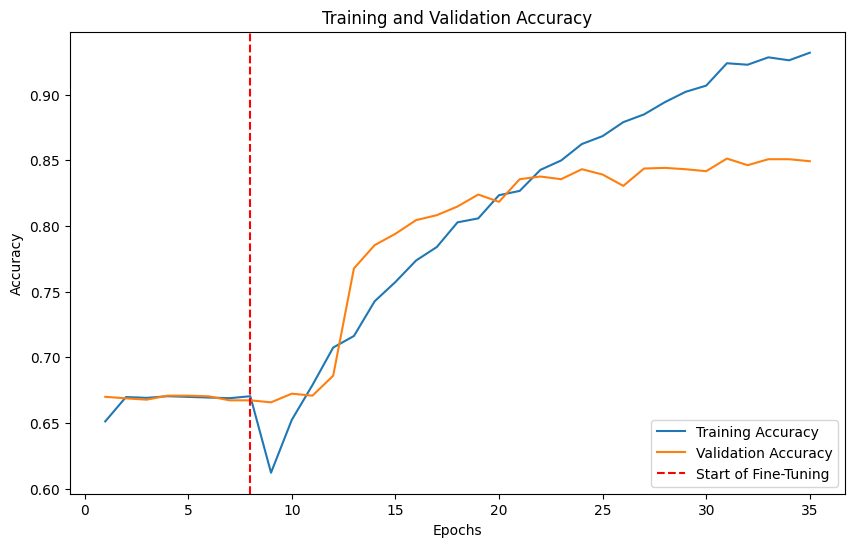

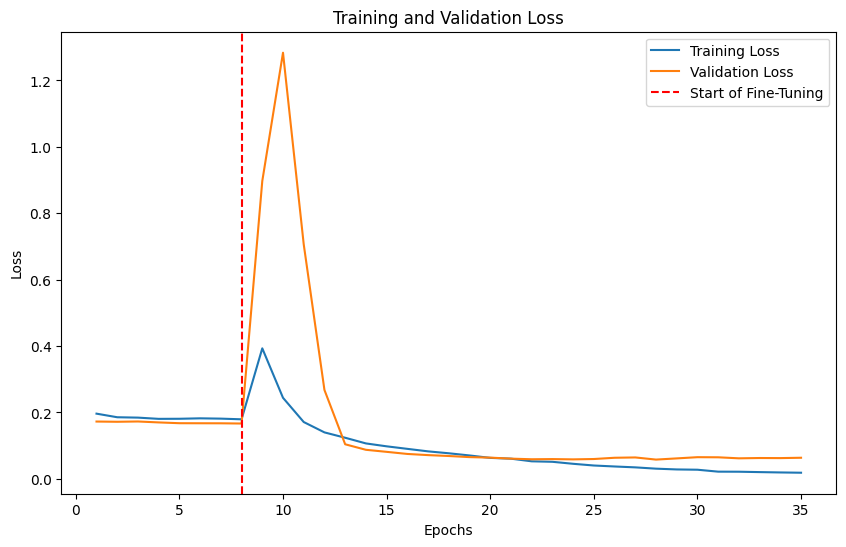

In [43]:
accuracy = history.history['accuracy'] + fine_tune_history.history['accuracy']
val_accuracy = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
loss = history.history['loss'] + fine_tune_history.history['loss']
val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.axvline(x=len(history.history['accuracy']), color='r', linestyle='--', label='Start of Fine-Tuning')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.axvline(x=len(history.history['loss']), color='r', linestyle='--', label='Start of Fine-Tuning')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [44]:
y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = test_generator.classes

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 258ms/step
Classification Report:
               precision    recall  f1-score   support

       akiec       0.67      0.54      0.60        65
         bcc       0.83      0.62      0.71       103
         bkl       0.59      0.80      0.68       220
          df       0.61      0.74      0.67        23
         mel       0.67      0.55      0.60       223
          nv       0.93      0.93      0.93      1341
        vasc       0.96      0.82      0.88        28

    accuracy                           0.84      2003
   macro avg       0.75      0.72      0.73      2003
weighted avg       0.85      0.84      0.84      2003



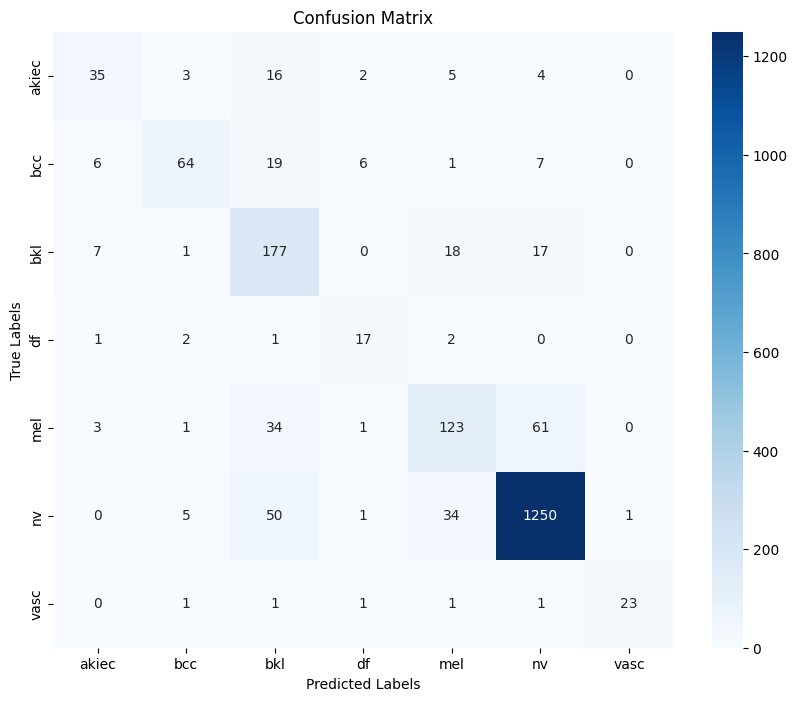

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


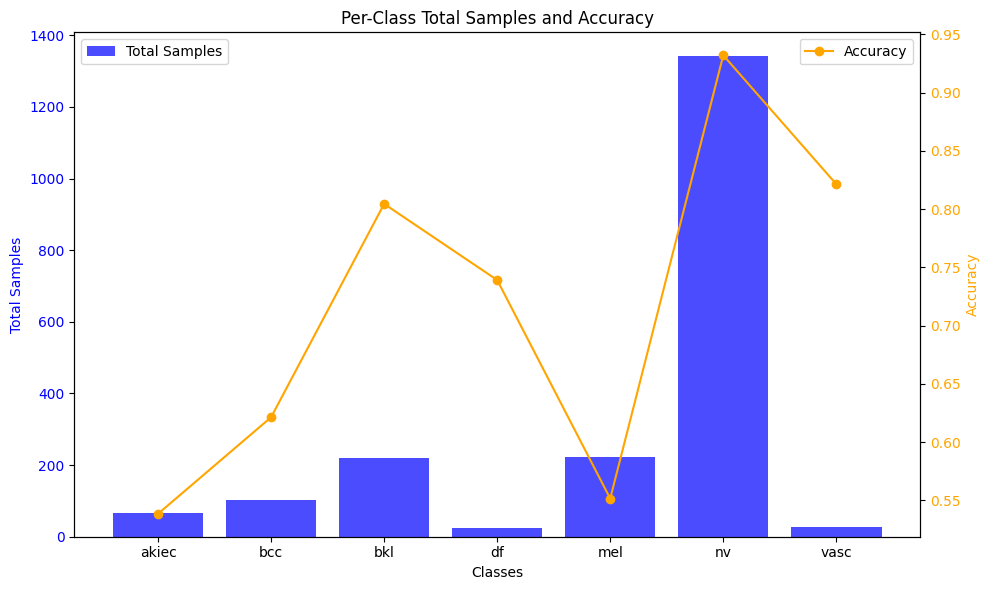

In [46]:
label_counts = np.bincount(y_true)
class_accuracies = np.diag(cm) / label_counts

classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
total_counts = label_counts
accuracies = class_accuracies

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(classes, total_counts, alpha=0.7, label='Total Samples', color='blue')
ax1.set_xlabel('Classes')
ax1.set_ylabel('Total Samples', color='blue')
ax1.set_title('Per-Class Total Samples and Accuracy')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(classes, accuracies, color='orange', marker='o', label='Accuracy')
ax2.set_ylabel('Accuracy', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

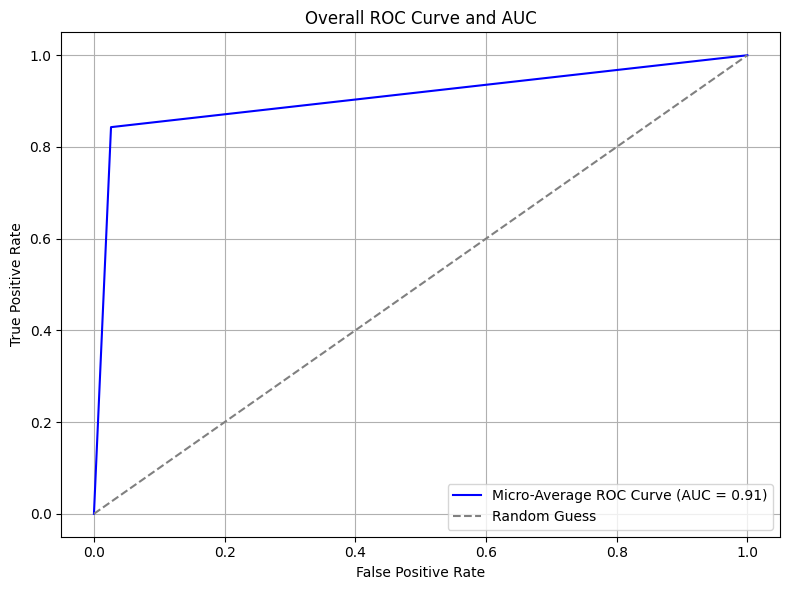

In [47]:
num_classes = len(classes)
y_true_one_hot = label_binarize(y_true, classes=np.arange(num_classes))

y_pred_prob = np.zeros_like(y_true_one_hot)
for i, label in enumerate(y_pred):
    y_pred_prob[i, label] = 1

fpr, tpr, _ = roc_curve(y_true_one_hot.ravel(), y_pred_prob.ravel())
roc_auc = roc_auc_score(y_true_one_hot, y_pred_prob, average="micro")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"Micro-Average ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Overall ROC Curve and AUC")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


In [48]:
print("ROC AUC Score (Micro):", roc_auc_score(y_true, y_pred_prob, multi_class='ovr', average='micro'))
print("ROC AUC Score (Macro):", roc_auc_score(y_true, y_pred_prob, multi_class='ovr', average='macro'))
print("ROC AUC Score (Weighted):", roc_auc_score(y_true, y_pred_prob, multi_class='ovr', average='weighted'))

print("AUC Scores Per Class:")
for i, class_name in enumerate(class_names):
    class_roc_auc = roc_auc_score(y_true_one_hot[:, i], y_pred_prob[:, i])
    print(f"{class_name}: {class_roc_auc:.2f}")

ROC AUC Score (Micro): 0.9085538359127975
ROC AUC Score (Macro): 0.8392053233449834
ROC AUC Score (Weighted): 0.8701198018495033
AUC Scores Per Class:
akiec: 0.76
bcc: 0.81
bkl: 0.87
df: 0.87
mel: 0.76
nv: 0.90
vasc: 0.91
